<a href="https://colab.research.google.com/github/bharath-r17/brain-mri-classifcation/blob/main/BrainMRI_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Dataset
Opendatasets library is insatlled and it is used to download the Brain Tumor Classification (MRI) datset from Kaggle.
 [Link to the dataset](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri/download'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bharathr17
Your Kaggle Key: ··········


  0%|          | 0.00/86.8M [00:00<?, ?B/s]

100%|██████████| 86.8M/86.8M [00:01<00:00, 83.0MB/s]


### Importing the necessary libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Checking the data

In [ ]:
DATA_DIR = './brain-tumor-classification-mri'
print(os.listdir(DATA_DIR))

['Training', 'Testing']


In [ ]:
print(os.listdir(DATA_DIR))
classes = os.listdir(DATA_DIR + "/Training")
print(classes)

['Training', 'Testing']
['no_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor']


The dataset contains 2 folders named "Testing" and "Training". These folders in turn conatin 4 folders named 'glioma_tumor', 'meningioma_tumor', 'no_tumor' and 'pituitary_tumor' cotaining images of the respective classes.


In [ ]:
img = os.listdir(DATA_DIR + "/Training/pituitary_tumor")

512 512


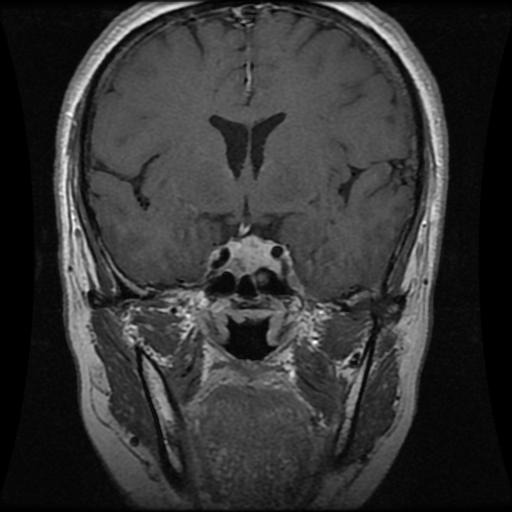

In [ ]:
from PIL import Image
im = Image.open('./brain-tumor-classification-mri/Training/pituitary_tumor/p (47).jpg')
width, height = im.size
print(width, height)
im.convert('RGB')

An image from the pituitary_tumor category of the training dataset is displayed alongwith its resolution which is 512x512

#Data Preparation


In [ ]:
import torchvision.transforms as T

img_size = 512
# imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))
# train_tfms  = T.Compose([T.Resize((img_size,img_size)),
#                     T.Pad(16, padding_mode='constant'),
#                     T.RandomCrop(img_size),
#                     T.RandomHorizontalFlip(),
#                     T.ToTensor(), 
#                     T.Normalize(*imagenet_stats)])
train_tfms  = T.Compose([T.Resize((img_size,img_size)),
                    T.Pad(16, padding_mode='reflect'),
                    T.RandomCrop(img_size),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(), 
                    T.Normalize(*imagenet_stats)])
valid_tfms = T.Compose([T.Resize((img_size,img_size)),T.ToTensor(), T.Normalize(*imagenet_stats)])


For better results from the model certain changes are done to the datset.


1.   All the images are resized to 512x512 since some of them differ in their size
2.   Padding of 8 pixels is added onto the sides of the image in the form of reflection of the image.
3. The image is then again cropped randomly to get 512x512 pixels.
4. The images are flipped along their horizontal axis.
5. The image pixels are converted to tensor
6. Normalize all values so that they lie in range -1 to 1 using means and standard deviations for every channel



In [ ]:
# PyTorch datasets
train_ds = ImageFolder(DATA_DIR + "/Training",train_tfms )
valid_ds = ImageFolder(DATA_DIR + "/Testing" ,valid_tfms)

The trasforms are applied to the training and testing datsets and are saved as an image folder

In [ ]:
# PyTorch data loaders
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


A batch size of 64 is defined. Batches of data are created using DataLoader function.

#Defining the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

Accurcy function is defined to help calculate the accuracy of the predictions. An image classification base class is defined which inherits from the nn.module. 

In [ ]:
from torchvision import models

class MRIModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

A pretrained ResNet18 model is used to train our model. The  model is named MRIModel and it inherits from our previously created image classification base class.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Functions are created to check if a GPU is available and if it's availabe the data is moved to a GPU else it's moved to a CPU.

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

Type = CUDA means a GPU is available

#Training the Model

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
model = MRIModel(4)
to_device(model, device);

The model is moved to the GPU

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.197265625, 'val_loss': 1.6330218315124512}]

Before training the model we get an accuracy of 40% since the model makes a random guess

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
# opt_func = torch.optim.AdamW #780
opt_func = torch.optim.Adamax

We define the following hyperparametrs.

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0],last_lr: 0.00388, train_loss: 0.4366, val_loss: 2.9842, val_acc: 0.2520



Epoch [1],last_lr: 0.00935, train_loss: 0.3846, val_loss: 46.8183, val_acc: 0.2344



Epoch [2],last_lr: 0.00972, train_loss: 0.4468, val_loss: 1.7500, val_acc: 0.6125



Epoch [3],last_lr: 0.00812, train_loss: 0.2362, val_loss: 1.6170, val_acc: 0.6973



Epoch [4],last_lr: 0.00556, train_loss: 0.1813, val_loss: 1.3394, val_acc: 0.7406



Epoch [5],last_lr: 0.00283, train_loss: 0.0980, val_loss: 1.2278, val_acc: 0.8066



Epoch [6],last_lr: 0.00077, train_loss: 0.0756, val_loss: 1.3539, val_acc: 0.8027



Epoch [7],last_lr: 0.00000, train_loss: 0.0506, val_loss: 1.3082, val_acc: 0.8066
CPU times: user 2min 22s, sys: 2min 29s, total: 4min 51s
Wall time: 6min 47s


The model is trained for 8 epochs and validation accuracy of 80.66% is  obtained. The model takes 6:46 minutes to train

##Plotting the Results

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

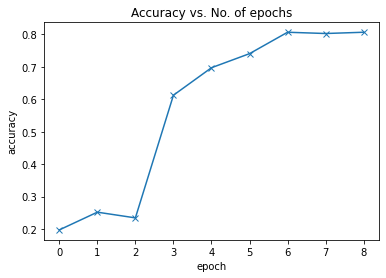

In [ ]:
plot_accuracies(history)

The accuracy jumps around a bit. It decreases initially followed by a sudden jump and a small fall. Later it increases gradually before becoming constant.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]
    plt.subplot(1, 2, 1)

    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.title('Validation Loss vs. No. of epochs');
    plt.subplot(1, 2, 2)

    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.title('Training Loss vs. No. of epochs');

    plt.subplots_adjust(left=0.1,
                      right=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
      
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


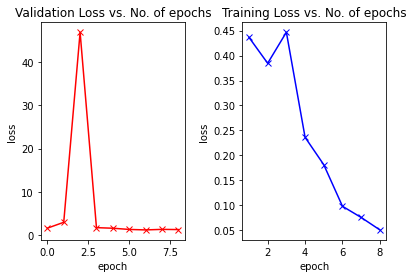

In [ ]:
plot_losses(history)

The lossed for validationn and training are plotted side by side since the ranges of values are differnt for both. The validation starts very low but suddenly increases to a very high value and later comes down. The training loss starts low and keeps decreasing. The training and validation lossses are both very less by the 8th epoch

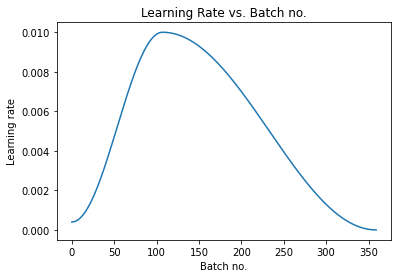

In [ ]:
plot_lrs(history)

Fit one cycle policy is used. The learing rate starts low and increses to a maximum and later decreases gradually.

#Testing

In [ ]:
def denormalize_image(img, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return img * stds + means

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Functions are defined to denormalise the image and to predict the result

###Prediction 1

Label: glioma_tumor , Predicted: glioma_tumor


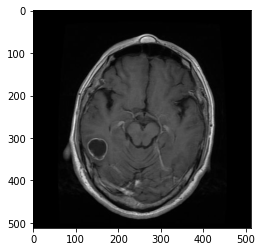

In [ ]:
img, label = valid_ds[74]
plt.imshow(denormalize_image(img, *imagenet_stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

###Prediction 2

Label: meningioma_tumor , Predicted: meningioma_tumor


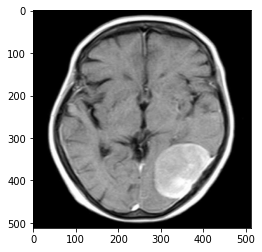

In [ ]:

img, label = valid_ds[104]
plt.imshow(denormalize_image(img, *imagenet_stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

###Prediction 3

Label: no_tumor , Predicted: no_tumor


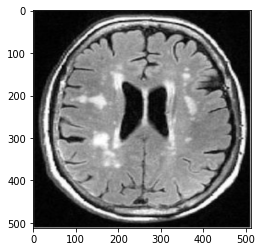

In [ ]:
img, label = valid_ds[254]
plt.imshow(denormalize_image(img, *imagenet_stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

###Prediction 4

Label: glioma_tumor , Predicted: meningioma_tumor


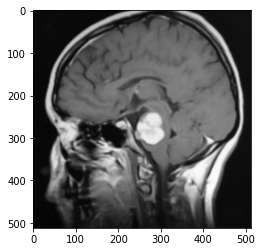

In [ ]:
img, label = valid_ds[9]
plt.imshow(denormalize_image(img, *imagenet_stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Some of the glioma tumour pictures are wrongly being classified. Will have to look into the reason and improve the performance of the model.